In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
import random


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torch.autograd import Variable

from torchvision import transforms as tf

from skimage.io import imread

from pathlib import Path
import nibabel as nib

# from tqdm import tqdm

from imgaug import augmenters as iaa

from utils.display_utils import image_grid, image_gray
from utils.neuron_dataset import Neuron_dataset
from networks.Unet_no_z_pool import Unet

from networks.Att_Net import Model_B_E, Model_B_C_E
from utils.trainer import train_loop

In [2]:
path = 'data/'

In [3]:
img = imread(path+'train-input.tif')
# label = imread(path+'new_labels_.tif')
label3 = imread(path+'new_labels_3x3_f.tif')
label2 = imread(path+'new_labels_2x2.tif')
(img.shape, label3.shape, label2.shape)

((100, 1024, 1024), (100, 1024, 1024), (100, 1024, 1024))

In [4]:
img =np.rollaxis(img, 0,3)
# label = np.rollaxis(label,0,3)
label2 = np.rollaxis(label2,0,3)
label3= np.rollaxis(label3,0,3)

<Figure size 432x288 with 0 Axes>

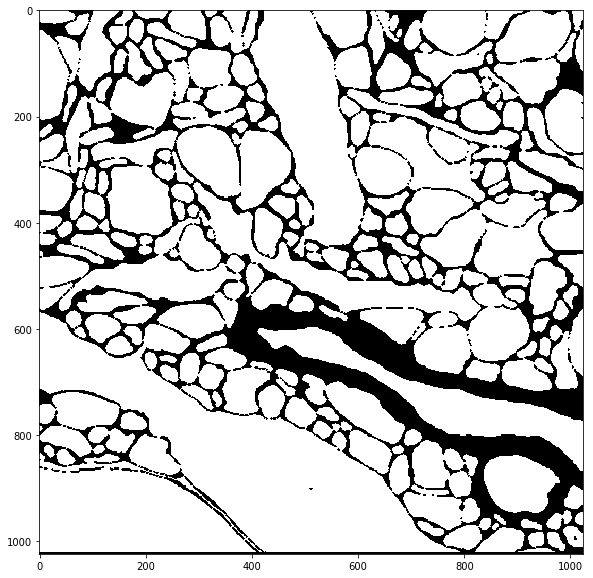

In [5]:
image_gray(label2[:,:,0])

In [6]:

train_l = 10000
val_l = 2000
dim_z = 6
dim_x = 64
dim_y = 64
X_train = np.zeros((train_l, dim_x, dim_y, dim_z), dtype=np.float32)
Y_train = np.zeros((train_l, dim_x, dim_y, dim_z), dtype=np.float32)

X_val = np.zeros((val_l, dim_x, dim_y, dim_z), dtype=np.float32)
Y_val = np.zeros((val_l, dim_x, dim_y, dim_z), dtype=np.float32)

#top 80
half = 32
for i in range(0,10000):
    x = np.random.randint(half,1024-half)
    y = np.random.randint(half,1024-half)
    z = np.random.randint(3,77)
    
    label_pick = np.random.randint(2)
    X_train[i] = img[x-half:x+half,y-half:y+half,z-3:z+3]
    if label_pick==0:
        Y_train[i] = label2[x-half:x+half,y-half:y+half,z-3:z+3]
    else:
        Y_train[i] = label3[x-half:x+half,y-half:y+half,z-3:z+3]

#bottom 20
for i in range(0,2000):
    x = np.random.randint(half,1024-half)
    y = np.random.randint(half,1024-half)
    z = np.random.randint(83,97)
   
    label_pick = np.random.randint(2)
    X_val[i] = img[x-half:x+half,y-half:y+half,z-3:z+3]
    if label_pick ==0:
        Y_val[i] = label2[x-half:x+half,y-half:y+half,z-3:z+3]
    else:
        Y_val[i] = label3[x-half:x+half,y-half:y+half,z-3:z+3]
    
X_train = X_train/255
X_val = X_val/255

In [7]:
neuron_dataset_train = Neuron_dataset(X_train, 
                                      train=True, 
                                      masks=Y_train,
                                      transform=True)

neuron_dataset_val = Neuron_dataset(X_val, 
                                      train=True, 
                                      masks=Y_val,
                                      transform=False)

batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset=neuron_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=neuron_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=True)



<Figure size 432x288 with 0 Axes>

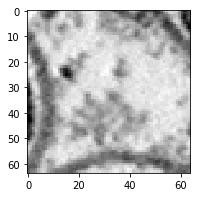

torch.Size([64, 64, 6])


In [8]:
get_image = next(iter(train_loader))
im = get_image[0][0].squeeze()
image_gray(im[:,:,4],3)
print(im.shape)

In [9]:
im=get_image[0]
im.shape

torch.Size([32, 1, 64, 64, 6])

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [11]:
# model = Model_B_E(32)
model = Model_B_C_E(32,8)
# model = Unet()
model.to(device)
# criterion = nn.BCEWithLogitsLoss()\n",


Model_B_C_E(
  (input_conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (block_1): Block_B(
    (top_bn_relu): Sequential(
      (0): BatchNorm3d(32, eps=1e-05, momentum=0.997, affine=True, track_running_stats=True)
      (1): ReLU6(inplace)
    )
    (projection): Sequential(
      (0): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    )
    (residual): Sequential(
      (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.997, affine=True, track_running_stats=True)
      (2): ReLU6(inplace)
      (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
  )
  (block_2): Block_B(
    (top_bn_relu): Sequential(
      (0): BatchNorm3d(32, eps=1e-05, momentum=0.997, affine=True, track_running_stats=True)
      (1): ReLU6(inplace)
    )
    (projection): Sequential(
      (0): Conv3d(32, 64, kernel_size=(1, 1, 1), stride=(2, 2, 2))
    )
    (

In [12]:
criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=.1)


scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, 
                                                 milestones=[100,200,400,500], gamma=0.1)


In [13]:
save_bst = 'experiments/att/exp1/best.pth'
save_last = 'experiments/att/exp1/last_600.pth'
hist = train_loop(train_loader,val_loader,model,optimizer,scheduler,criterion,
                 save_bst,save_last,600)

EPOCH:  1


/workspace/ML/pytorch_proj/seg_neurites/3d_segmentation/networks/attention.py:261: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = F.softmax(logits)


Training loss:....... 0.6727779821846813
Validation loss:..... 0.6440518706563919
NEW BEST Loss: 0.6440518706563919 ........old best:99999


EPOCH:  2
Training loss:....... 0.5885019631812367
Validation loss:..... 0.5816453676375132
NEW BEST Loss: 0.5816453676375132 ........old best:0.6440518706563919


EPOCH:  3
Training loss:....... 0.5354796379518966
Validation loss:..... 0.5670267873340182
NEW BEST Loss: 0.5670267873340182 ........old best:0.5816453676375132


EPOCH:  4
Training loss:....... 0.5082727584975977
Validation loss:..... 0.5545166163217454
NEW BEST Loss: 0.5545166163217454 ........old best:0.5670267873340182


EPOCH:  5
Training loss:....... 0.4949096552670573
Validation loss:..... 0.5253534170370253
NEW BEST Loss: 0.5253534170370253 ........old best:0.5545166163217454


EPOCH:  6
Training loss:....... 0.48764511247793324
Validation loss:..... 0.5016180494474987
NEW BEST Loss: 0.5016180494474987 ........old best:0.5253534170370253


EPOCH:  7
Training loss:....... 0.4810

Training loss:....... 0.28722619639037134
Validation loss:..... 0.28600384342292

EPOCH:  64
Training loss:....... 0.2846757539164144
Validation loss:..... 0.2930441761300677

EPOCH:  65
Training loss:....... 0.2844789477106862
Validation loss:..... 0.2796086188819673

EPOCH:  66
Training loss:....... 0.2826391228566916
Validation loss:..... 0.3051469974101536

EPOCH:  67
Training loss:....... 0.2812477493057617
Validation loss:..... 0.28676070887891075

EPOCH:  68
Training loss:....... 0.28166967254286757
Validation loss:..... 0.2779089439482916
NEW BEST Loss: 0.2779089439482916 ........old best:0.2781668676743432


EPOCH:  69
Training loss:....... 0.28206716211268695
Validation loss:..... 0.2760221054629674
NEW BEST Loss: 0.2760221054629674 ........old best:0.2779089439482916


EPOCH:  70
Training loss:....... 0.2790885675258149
Validation loss:..... 0.2814449656104285

EPOCH:  71
Training loss:....... 0.2782174264089749
Validation loss:..... 0.2744973694521283
NEW BEST Loss: 0.27449

Validation loss:..... 0.2527624415972876

EPOCH:  140
Training loss:....... 0.25432705488829566
Validation loss:..... 0.2480708117049838

EPOCH:  141
Training loss:....... 0.25483025124849984
Validation loss:..... 0.25039166141124

EPOCH:  142
Training loss:....... 0.25480133295059204
Validation loss:..... 0.24971287354590402

EPOCH:  143
Training loss:....... 0.25426762510602846
Validation loss:..... 0.2627619959059216

EPOCH:  144
Training loss:....... 0.2548961269493682
Validation loss:..... 0.26189098613602774

EPOCH:  145
Training loss:....... 0.2548045662645334
Validation loss:..... 0.26186209585931564

EPOCH:  146
Training loss:....... 0.2541290603030604
Validation loss:..... 0.252525143443592

EPOCH:  147
Training loss:....... 0.2544365764235536
Validation loss:..... 0.2486663063367208

EPOCH:  148
Training loss:....... 0.25362565951606336
Validation loss:..... 0.2559108024551755

EPOCH:  149
Training loss:....... 0.2540950840368819
Validation loss:..... 0.25112834407223594

EP

KeyboardInterrupt: 

In [ ]:
([32, 1, 64, 64, 6])